# import

In [457]:
import sys
import os
import math
import numpy as np
import pandas as pd 
import xarray as xr
from scipy.stats import zscore
import matplotlib.pyplot as plt
import configparser



sys.path.insert(0, ".")

from minian.utilities import (
    open_minian,
    match_information,
    match_path
)


# Settings

In [458]:
# Define the bin
# how long each bin(unit is ms)

binSize = 10000  
binName = '10sec'


## Behavior settings

In [459]:
# Type of behavior and timewindow of each event
# for example 'ALP':[-18,18] means ALP event observe from W-18 to W18 
event_dict = {'ALP':[-18,18],'IALP':[-18,18], 'RNFS':[-18,18], 'ALP_Timeout':[-18,18]}

In [460]:
# event list and output list
event_list = [key for key in event_dict]
readout_list = ["AUC", "Frq", "Amp"]

In [461]:
# Data settings
# dpath is the session folder path.
# match_information and match_path is the same one in behavior_ms.ipynb if the folder structure changes, you can change it in the utilitis.py
dpath = "/N/project/Cortical_Calcium_Image/Miniscope data/03.2023_Eighth_group/AA051_D8/2023_03_13/13_42_12/Miniscope_2/S4"
mouseID, day, session = match_information(dpath)
#  calclulation the bin number manually
if session == 'S1':
    startBin = 0
    endBin = 89
elif session == 'S4':
    startBin = 270
    endBin = 359

mouse_path, video_path = match_path(dpath)
timeStamp = os.path.join(video_path,"timeStamps.csv")
minian_ds_path = os.path.join(dpath, "minian")
# Change the output date and project name or path.
output_dpath = "/N/project/Cortical_Calcium_Image/data_analysis_Project1_"+binName+"_Feb28th"
output_path = os.path.join(output_dpath, mouseID,day,session)
behavior_data=pd.read_csv(os.path.join(mouse_path, mouseID+"_"+day+"_"+session+"_behavior_ms.csv"),sep=',')


if(os.path.exists(output_path) == False):
    os.makedirs(output_path)

# Load data

In [462]:
data = open_minian(minian_ds_path)

In [463]:
# get all the neuron ids
neuron_ids = data['C'].coords['unit_id'].values

In [464]:
data

<xarray.Dataset>
Dimensions:      (frame: 27000, height: 608, shift_dim: 2, unit_id: 59, width: 608)
Coordinates:
    animal       <U11 'Miniscope_2'
  * height       (height) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
    session      <U2 'S4'
  * unit_id      (unit_id) int64 0 1 3 5 6 7 9 10 11 ... 78 79 80 81 82 83 84 85
    unit_labels  (unit_id) int64 dask.array<chunksize=(59,), meta=np.ndarray>
  * width        (width) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
  * frame        (frame) int64 76 77 78 79 80 ... 27071 27072 27073 27074 27075
  * shift_dim    (shift_dim) <U6 'height' 'width'
Data variables:
    A            (unit_id, height, width) float64 dask.array<chunksize=(1, 608, 608), meta=np.ndarray>
    f            (frame) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    max_proj     (height, width) uint8 dask.array<chunksize=(608, 608), meta=np.ndarray>
    b0           (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    c0           (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    S            (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    C            (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    motion       (frame, shift_dim) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    b            (height, width) float64 dask.array<chunksize=(608, 608), meta=np.ndarray>

# Traces

In [465]:
# Plot traces from multiple neurons and the event
def plot_multiple_traces(data, neurons_to_plot, behavior_data = None,shift_amount=0.4):
    shifts = [shift_amount * i for i in range(len(neurons_to_plot))]
    y=shifts[-1]+10
    fig, ax = plt.subplots(figsize=(30.4,y))
    for shift, neuron in zip(shifts, neurons_to_plot):
        trace = data['C'].sel(unit_id=neuron)
        trace /= np.max(trace)
    #        ax.autoscale()
        ax.text(behavior_data['Time Stamp (ms)'][0],shift,neuron)
        ax.plot(behavior_data['Time Stamp (ms)'],trace + shift,alpha=0.75)
    if behavior_data is not None:
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['RNFS']>0],0,shifts[-1] + 1,color="green")
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['IALP']>0],0,shifts[-1] + 1,color="blue")
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['ALP_Timeout']>0],0,shifts[-1] + 1,color="yellow")
    
    ax.set_xlabel('Time Stamp (ms)')
    ax.set_ylabel('Neurons')
    ax.set_yticks([])
#     fig.savefig(os.path.join(output_path, mouseID+'_'+ day + session+"_trace_ms.pdf"))

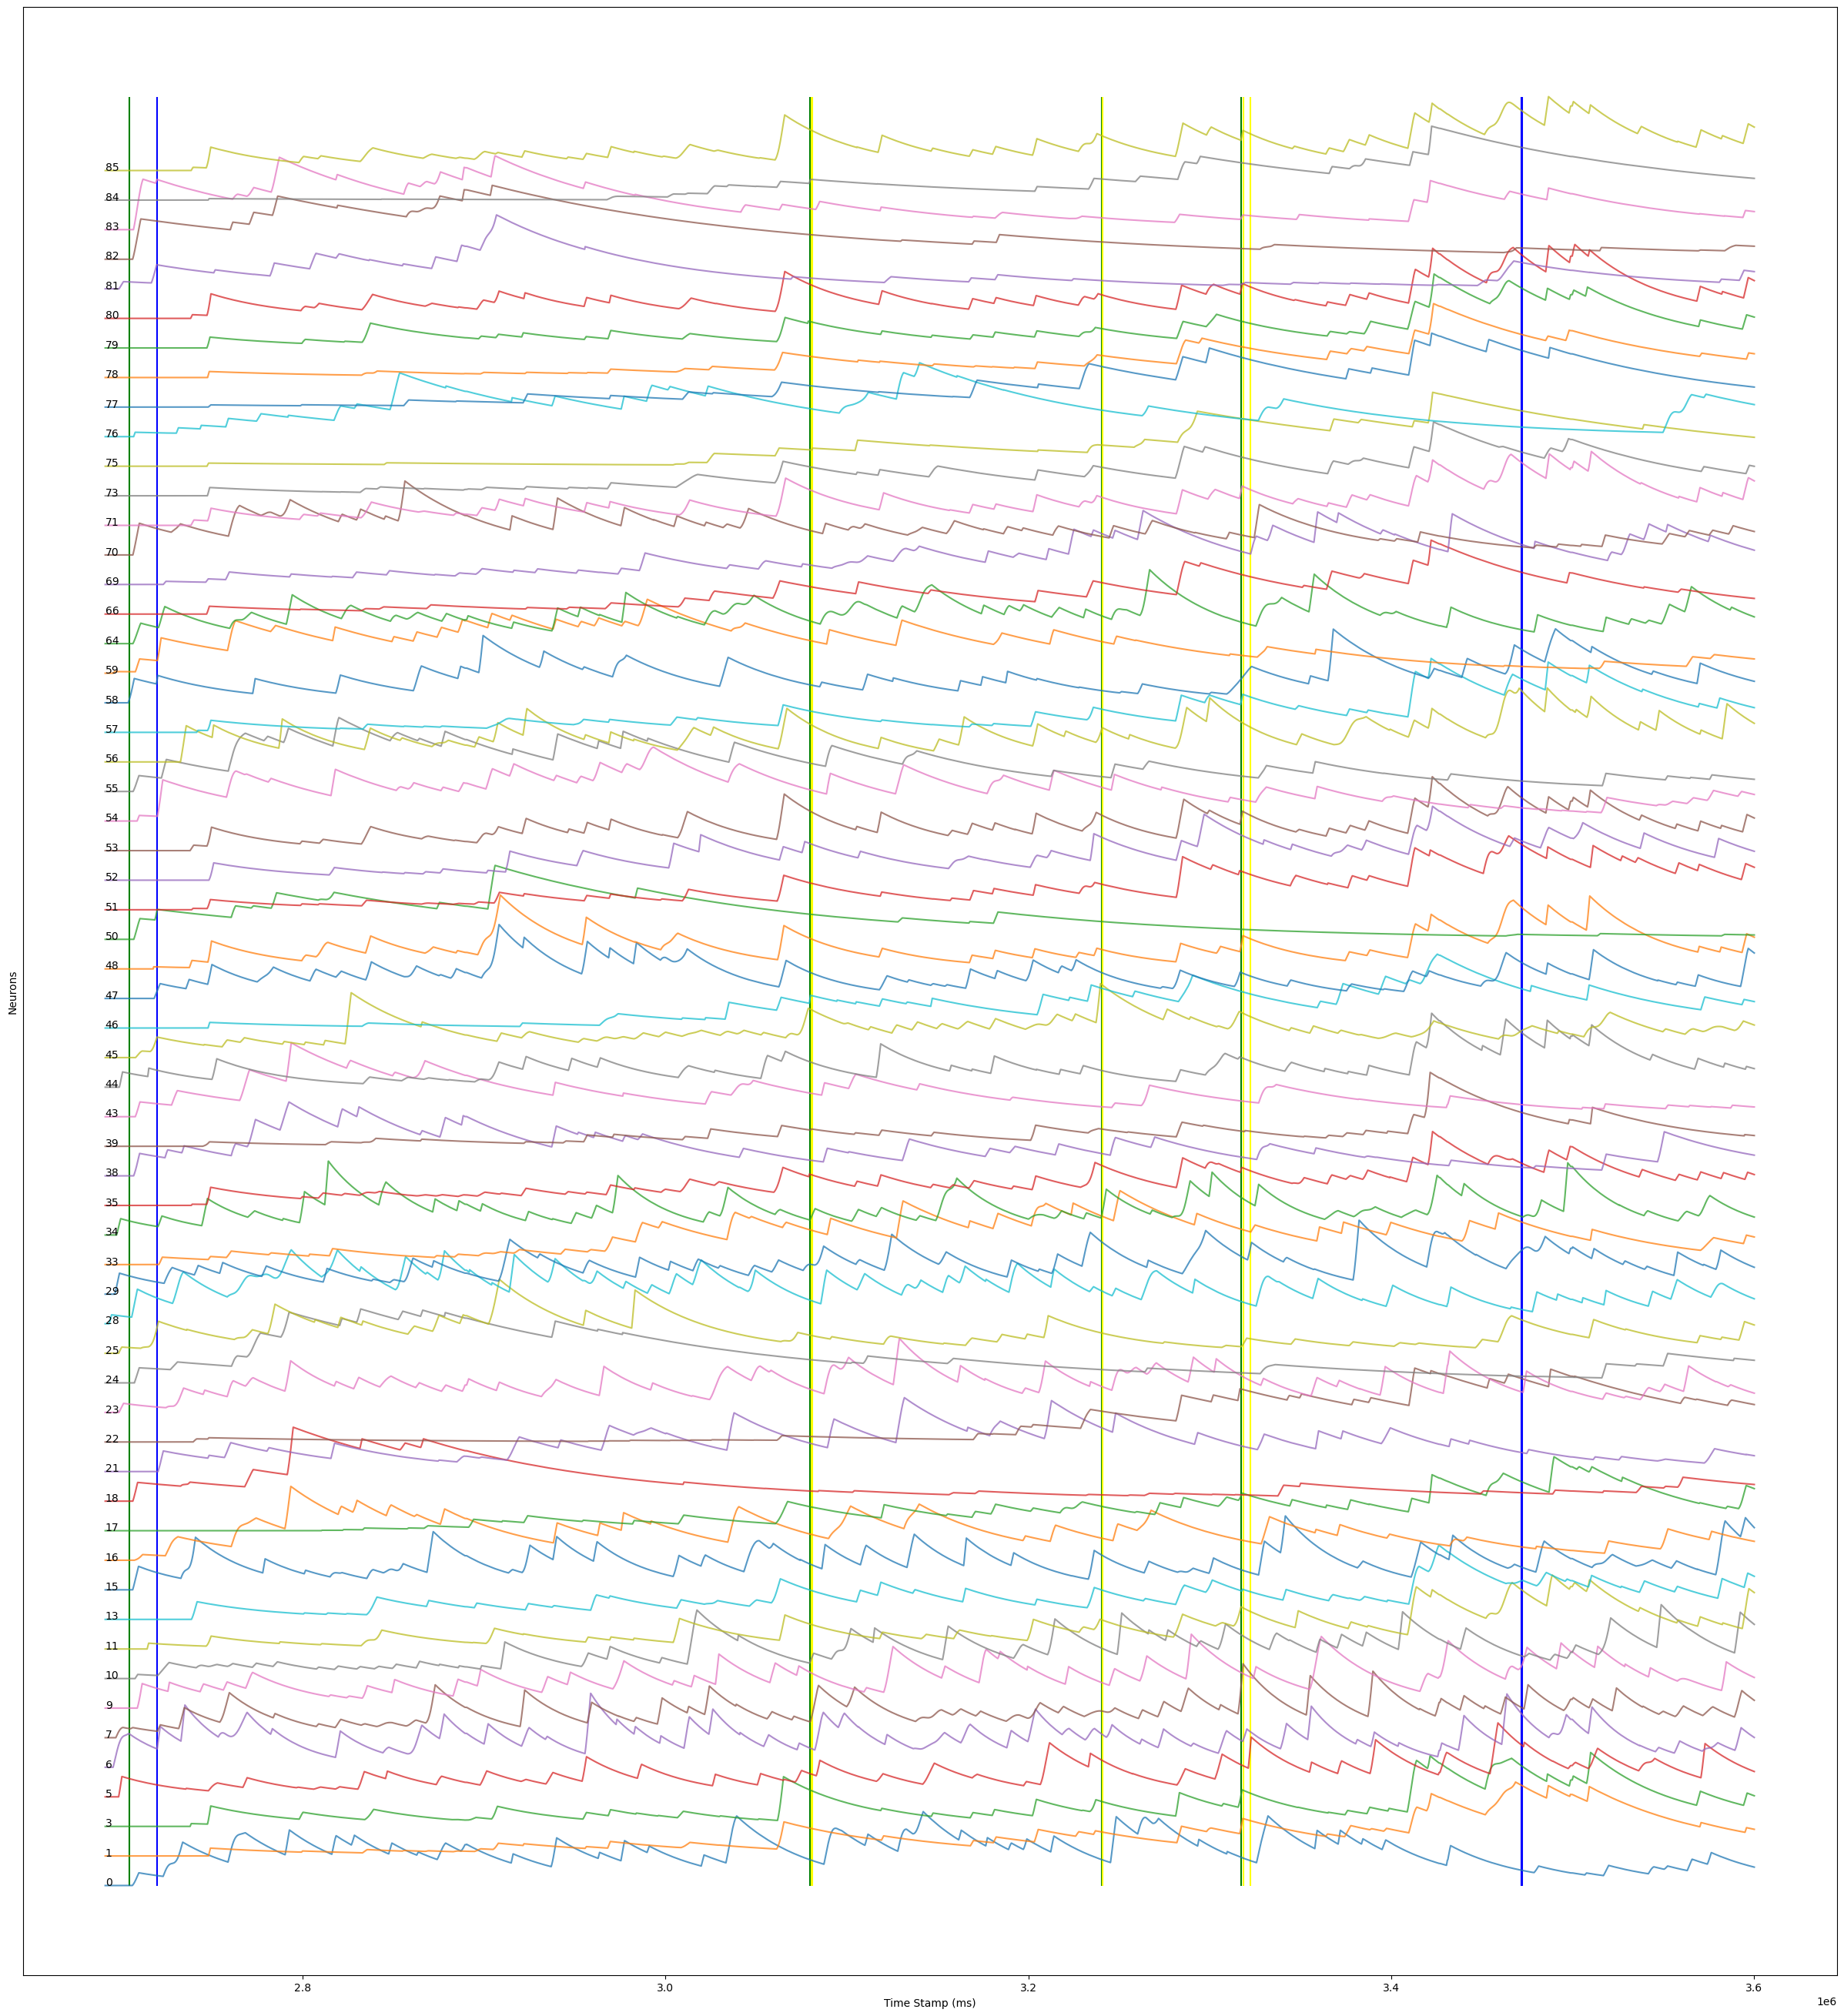

In [466]:
plot_multiple_traces(data,neuron_ids,behavior_data)

## zscore functions

In [467]:
# Contains left and right ends
def calculate_window(analyzed_zscore_df, action , time_window):
    start = time_window[0]
    end = time_window[1]
    output_df = analyzed_zscore_df
    for i in range(start,end + 1):
        # only line 2 so the mean is the same to line 2.
        series_positive = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) > 0].mean()
        series_positive.name = action+"_positive_W"+str(i)
        series_negative = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) == 0].mean()
        series_negative.name = action+"_negative_W"+str(i)
        output_df = output_df.append(series_positive)
        output_df = output_df.append(series_negative)
    return output_df

In [468]:
def calculate_zscore (session, input_df):
    neuron_ids = input_df.columns.values.tolist()
    neuron_ids = list(filter(lambda x:type(x) == int,neuron_ids))
#     if session == "S1":
#         analyzed_df = input_df.loc[0:14,:]
#     elif session == "S4":
#         analyzed_df = input_df.loc[45:59,:]
    analyzed_df = input_df.loc[startBin:endBin,:]
    neuron_value = analyzed_df.loc[:,neuron_ids]
    behavior_value = analyzed_df.loc[:,event_list]
    zscore_df = zscore(neuron_value,axis = 0)
    sum_zscore_df = pd.merge(zscore_df,behavior_value,left_index=True,right_index=True)
#     print(sum_zscore_df)
    output_zscore_df = sum_zscore_df
    for event in event_dict:
        output_zscore_df = calculate_window(output_zscore_df, event, event_dict[event])
    return output_zscore_df

In [469]:
def calculate_mean(Series,ngtv_near=0.1,ngtv_far=0,pstv_near=0.1,pstv_far=0):
    series=Series.sort_values()
    # total number
    total = len(Series)
    print('total',total)
    print(Series.to_list())
    
    # ngtv number
    ngtv_series= series[series<0]
    ngtv_number = len(ngtv_series)
    
    # pstv number
    pstv_series = series[series>0]
    pstv_number = len(pstv_series)
    
    # number of ngtv be analyzed
    ngtv_series_analyzed = ngtv_series[round(len(ngtv_series)*ngtv_far):round(len(ngtv_series)*(1-ngtv_near))]
    ngtv_analyzed_number = len(ngtv_series_analyzed)
    
    # analyzed ngtv neuron ID
    ngtv_neurons_list = ngtv_series_analyzed.index.to_list()
    ngtv_neurons=','.join([str(i) for i in ngtv_neurons_list])
#     print(ngtv_neurons)
    
    # analyzed ngtv neuron zscore
    ngtv_neurons_zscore_list = ngtv_series_analyzed.values.tolist()
    ngtv_neurons_zscore = ','.join([str(i) for i in ngtv_neurons_zscore_list])
#     print(ngtv_neurons_zscore)
#     print(type(ngtv_neurons_zscore))
    
    # ngtv mean
    ngtv_mean = ngtv_series_analyzed.mean()
    
    # number of pstv be analyzed
    pstv_series_analyzed = pstv_series[round(len(pstv_series)*pstv_near):round(len(pstv_series)*(1-pstv_far))]
    pstv_analyzed_number = len(pstv_series_analyzed)
    
    # analyzed pstv neuron ID
    pstv_neurons_list = pstv_series_analyzed.index.to_list()
    pstv_neurons=','.join([str(i) for i in pstv_neurons_list])
#     print(pstv_neurons)
    
    # analyzed pstv neuron zscore
    pstv_neurons_zscore_list = pstv_series_analyzed.values.tolist()
    pstv_neurons_zscore = ','.join([str(i) for i in pstv_neurons_zscore_list])
#     print(pstv_neurons_zscore)
#     print(type(pstv_neurons_zscore))
    
    # pstv mean
    pstv_mean = pstv_series_analyzed.mean()
    
    out = pd.Series([total,ngtv_number,ngtv_near,ngtv_far,ngtv_analyzed_number,ngtv_neurons,ngtv_neurons_zscore,ngtv_mean,pstv_number,pstv_near,pstv_far,pstv_analyzed_number,pstv_neurons,pstv_neurons_zscore,pstv_mean],index=["total neuron","ngtv neuron","near (%) in the ngtv side", "far (%) in the ngtv side","ngtv neuron to be analyzed","analyzed ngtv neuron ID","analyzed ngtv zscore","negative mean","pstv neuron","near (%) in the pstv side","far (%) in the pstv side","pstv neuron to be analyzed","analyzed pstv neuron ID","analyzed pstv zscore","positive mean"])
#     out = pd.concat([Series,out])
    return out

# Calculate AUC
## Merge behavior and timestamp


In [470]:
S_df = data['S'].to_pandas()  
S_df = S_df.transpose()

In [471]:
S_df.reset_index(drop=True, inplace = True)
total_pd = pd.merge(S_df, behavior_data,left_index = True,right_index = True,how = 'left')
total_pd

0    1    3    5    6    7    9   10   11   13  ...   83   84   85  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
8      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
12     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
13     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
15     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
16     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
17     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
18     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
20     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
21     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
23     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
24     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
26975  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26976  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26977  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26978  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26979  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26983  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26984  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26985  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26986  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ..

## AUC of S per Binsize

In [472]:
total_pd[binName]=total_pd['Time Stamp (ms)'].map(lambda x: math.floor(x/binSize))
pd.set_option('display.min_rows',50)
total_pd

0    1    3    5    6    7    9   10   11   13  ...   84   85  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
6      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
7      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
8      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
11     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
12     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
13     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
14     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
15     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
16     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
17     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
18     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
20     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
21     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
22     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
23     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
24     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
26975  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26976  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26977  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26978  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26979  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26983  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26984  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26985  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26986  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

       Frame Number  Time Stamp (ms)  Buffer Index  RNFS  ALP  IALP  \
0             80076          2691173             0     0    0     0   
1             8007

### Edit time manually

In [473]:
# total_pd[binName] = total_pd[binName]+ 216
total_pd

0    1    3    5    6    7    9   10   11   13  ...   84   85  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
6      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
7      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
8      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
9      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
11     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
12     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
13     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
14     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
15     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
16     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
17     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
18     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
19     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
20     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
21     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
22     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
23     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
24     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
26975  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26976  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26977  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26978  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26979  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26983  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26984  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26985  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26986  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
26999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

       Frame Number  Time Stamp (ms)  Buffer Index  RNFS  ALP  IALP  \
0             80076          2691173             0     0    0     0   
1             8007

In [474]:
AUC_pd = total_pd.groupby(binName).sum()
columns = neuron_ids.tolist()
columns = columns + event_list
AUC_pd = AUC_pd[columns]
AUC_pd

0         1         3         5         6         7         9  \
10sec                                                                         
269    0.005029  0.000000  0.000000  1.581434  3.448053  1.235238  0.000000   
270    0.884857  0.000000  0.000000  0.483433  1.159423  0.355606  0.722952   
271    0.000000  0.000000  0.000000  0.000000  0.285682  0.020182  1.379694   
272    1.211907  0.000000  0.000000  0.000000  2.415141  0.853812  0.785029   
273    1.506913  0.000000  0.134129  0.079193  4.396919  2.862443  0.000000   
274    0.000000  0.327316  0.878625  0.454782  0.000000  0.000000  0.728249   
275    0.629284  0.000000  0.000000  0.470159  0.989520  4.316601  0.773762   
276    2.049237  0.000000  0.000000  1.049980  4.251022  0.000000  0.584925   
277    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.960623   
278    0.000000  0.000000  0.000000  0.000000  0.757358  0.623538  0.000000   
279    1.829424  0.049260  0.326149  0.080705  0.000000  0.000000  0.000000   
280    0.000000  0.000000  0.026572  0.305154  0.000000  0.402072  0.000000   
281    1.407393  0.000000  0.000000  0.231004  2.229205  0.804214  0.154185   
282    0.778796  0.000000  0.000000  0.048795  0.935310  0.399632  0.174183   
283    0.000000  0.142244  0.540802  1.897469  0.000000  0.286629  1.122587   
284    0.836830  0.000000  0.000000  0.795351  0.868669  0.977050  0.616937   
285    0.000000  0.027725  0.000000  0.000000  0.306458  0.545623  0.534097   
286    0.262546  0.029331  0.000000  0.000000  3.640846  1.748494  0.000000   
287    1.373769  0.000000  0.000000  0.965114  3.146125  4.205923  0.000000   
288    0.562321  0.037013  0.028987  0.004977  0.000000  0.000000  1.516043   
289    0.030780  0.124644  0.162744  0.900150  0.031030  0.000000  1.484501   
290    0.000000  0.273999  0.641212  0.678529  2.526206  0.000000  0.000000   
291    0.657553  0.000000  0.000000  0.000000  0.000000  0.186306  0.000000   
292    0.000000  0.074119  0.000000  0.317514  2.596051  4.678740  0.000000   
293    2.090804  0.000000  0.000000  1.331242  0.452563  0.000000  1.476091   
...         ...       ...       ...       ...       ...       ...       ...   
335    1.319492  0.000000  0.000000  1.075078  4.063894  5.298448  3.959840   
336    0.000000  0.114139  0.036403  0.000000  0.000000  0.000000  1.044830   
337    1.020848  0.510633  0.224868  1.428283  0.000000  0.000000  0.000000   
338    0.409676  0.061153  0.329977  1.832199  1.712869  6.144312  0.000000   
339    0.775688  0.139148  0.133030  1.838771  0.680437  0.000000  0.000000   
340    0.000000  0.112131  0.628212  0.000000  0.423272  0.000000  0.000000   
341    0.000000  1.143570  2.058520  0.000000  0.000000  0.155835  1.699151   
342    0.000000  0.691151  0.662953  2.348268  1.637459  2.532954  2.456659   
343    1.424297  0.000000  0.000000  0.244804  4.228790  2.058407  1.177496   
344    0.000000  0.000000  0.000000  0.000000  0.044086  0.054962  0.000000   
345    0.000000  0.939090  1.714376  5.613138  0.000000  0.425466  0.000000   
346    0.000000  0.982971  0.646037  0.000000  6.155455  2.458434  1.409454   
347    0.246215  0.000000  0.000000  0.492045  0.000000  3.401925  2.323451   
348    0.261975  0.548658  0.371954  0.027573  0.887849  0.000000  0.000000   
349    0.000000  0.102139  0.435927  0.498404  3.152609  2.084149  2.424244   
350    0.143692  0.650100  1.689400  0.882579  2.335294  0.821896  0.000000   
351    0.754054  0.000000  0.000000  2.022270  0.973624  0.721646  1.947917   
352    0.000000  0.000000  0.000000  0.000000  0.000000  3.219803  0.228849   
353    0.000000  0.000000  0.000000  1.070947  0.044690  0.143847  0.000000   
354    0.545927  0.000000  0.000000  0.956139  0.606606  0.632240  0.829041   
355    0.274691  0.000000  0.000000  0.000000  1.592613  1.415307  0.338331   
356    0.854132  0.000000  0.618187  0.000000  0.000000  0.405410  0.191552   
357    0.870521  0.185710  0.105091  3.608084  1.664700  1.72130

### Save data

In [475]:
AUC_pd.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_AUC_Ori.csv"))

### Zscore

In [476]:
AUC_zscore = calculate_zscore(session, AUC_pd)

#### Save Zscore

In [477]:
AUC_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_AUC_zscore.csv"))

### Summary

In [478]:
zscore_summary_index_list = list(filter(lambda x: type(x) != int,AUC_zscore.index.tolist()))
AUC_zscore_summary = AUC_zscore.loc[zscore_summary_index_list,:]
AUC_zscore_summary

0         1         3         5         6  \
10sec                                                                        
ALP_positive_W-18        -0.040726  0.666567  0.889769  0.139976 -0.261591   
ALP_negative_W-18         0.107571 -0.153462 -0.157590 -0.088573  0.000748   
ALP_positive_W-17        -0.354222 -0.314764 -0.156564  0.204746 -0.016006   
ALP_negative_W-17         0.117540 -0.048108 -0.064055 -0.068174 -0.014563   
ALP_positive_W-16         0.046911 -0.291669 -0.401021 -0.242507  0.637107   
ALP_negative_W-16         0.102595 -0.056665 -0.052952 -0.041082 -0.034518   
ALP_positive_W-15         0.475561 -0.291669 -0.401021 -0.252147  0.179911   
ALP_negative_W-15         0.059340 -0.063327 -0.059627 -0.049443 -0.013505   
ALP_positive_W-14         0.050114 -0.330476 -0.387359 -0.354996 -0.577526   
ALP_negative_W-14         0.077451 -0.016796 -0.012757  0.026328  0.027655   
ALP_positive_W-13        -0.211663 -0.152097 -0.184575  0.110420  0.384421   
ALP_negative_W-13         0.083692  0.015678 -0.013702 -0.015727  0.003916   
ALP_positive_W-12        -0.104685  0.182639  0.130226  0.493168  0.839394   
ALP_negative_W-12         0.068944 -0.014629 -0.042203 -0.044374 -0.039332   
ALP_positive_W-11         0.508031  0.101943 -0.019888  0.220366 -0.158786   
ALP_negative_W-11         0.020702  0.012134 -0.027212 -0.034093  0.024585   
ALP_positive_W-10         0.187425 -0.363886 -0.411304  0.439780 -0.250248   
ALP_negative_W-10         0.031373  0.041230  0.005384 -0.050760  0.046003   
ALP_positive_W-9         -0.650943 -0.240570 -0.191637 -0.089157 -0.112509   
ALP_negative_W-9          0.078314  0.058205  0.034023 -0.012810  0.044780   
ALP_positive_W-8          0.404150 -0.183672  0.048519 -0.350980  0.105078   
ALP_negative_W-8          0.011513  0.046962  0.011230  0.021288  0.026893   
ALP_positive_W-7          0.298521 -0.334395 -0.365534 -0.609630 -0.127929   
ALP_negative_W-7          0.008111  0.049316  0.030958  0.028947  0.030224   
ALP_positive_W-6          0.003688 -0.178874 -0.377688 -0.433077  0.363137   
...                            ...       ...       ...       ...       ...   
ALP_Timeout_negative_W6  -0.000819  0.038110  0.021543 -0.004473 -0.017120   
ALP_Timeout_positive_W7   0.013798  0.044733  0.020757  0.031874  0.005396   
ALP_Timeout_negative_W7  -0.006485  0.014493  0.004551  0.011645 -0.018505   
ALP_Timeout_positive_W8   0.024331  0.029280  0.011122  0.034848  0.004321   
ALP_Timeout_negative_W8  -0.017059  0.045229  0.025354  0.012886 -0.008961   
ALP_Timeout_positive_W9   0.015506  0.056775  0.042924  0.018343 -0.003225   
ALP_Timeout_negative_W9   0.004644  0.004490 -0.022709  0.046471  0.006967   
ALP_Timeout_positive_W10 -0.003479  0.068690  0.041152  0.031876 -0.003596   
ALP_Timeout_negative_W10  0.021834 -0.011715 -0.021282  0.029539  0.015255   
ALP_Timeout_positive_W11  0.028973  0.047078  0.018476  0.030509  0.023132   
ALP_Timeout_negative_W11 -0.024569  0.028927  0.020315  0.035360 -0.020916   
ALP_Timeout_positive_W12 -0.002222  0.045073  0.021357  0.045769  0.009280   
ALP_Timeout_negative_W12  0.017199  0.037199  0.020340  0.014666 -0.003134   
ALP_Timeout_positive_W13  0.024057  0.061143  0.031932  0.054997 -0.014241   
ALP_Timeout_negative_W13 -0.027594  0.016103  0.007929  0.005590  0.037481   
ALP_Timeout_positive_W14 -0.008498  0.070175  0.039472  0.061761  0.018019   
ALP_Timeout_negative_W14  0.032021  0.001908 -0.010069 -0.015210 -0.007008   
ALP_Timeout_positive_W15  0.010377  0.060060  0.027714  0.029366  0.015870   
ALP_Timeout_negative_W15 -0.001152  0.023349  0.013715  0.036427 -0.000656   
ALP_Timeout_positive_W16  0.029262  0.029553  0.013424  0.007280 -0.004376   
ALP_Timeout_negative_W16 -0.024350  0.076243  0.041336  0.077862  0.037761   
ALP_Timeout_positive_W17  0.002454  0.070504  0.044379  0.015600  0.001624   
ALP_Timeout_negative_W17  0.022300  0.015094 -0.003132  0.070633  0.015112   
ALP_Timeout_positive_W18  0.014892  0.048345  0.038537 

In [479]:
AUC_zscore_calculate_version1 = AUC_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
AUC_zscore_summary_version1 = pd.concat([AUC_zscore_summary,AUC_zscore_calculate_version1],axis=1)
AUC_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+day + session+"_AUC_10pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.04072553227705459, 0.6665669090573431, 0.8897692768253715, 0.13997626280562928, -0.2615912409286863, -0.47140654690085937, -0.3832655053662151, -0.47611719424620746, 0.4351263886577705, 0.14903190471340466, -0.1612375287806178, 0.06745537956007404, 0.4190102510455397, -0.330958421456518, -0.2319127763436147, -0.2525395938440502, -0.48346851085768516, -0.47815675765281496, 0.7028835705387133, -0.34875679089525435, -0.3819425009658972, -0.0695808468629527, -0.3014519564314584, 0.30648136135921783, -0.0028615676711696513, 0.1395990680868109, -0.29346226584196317, 0.13820883154378844, -0.07312175167036247, 0.22982533051588824, 1.1969628289852972, 1.4408783512021455, 1.2730437778492034, 0.4743944160857949, -0.20791135641545394, 0.732049969308451, 0.08579168440359639, -0.09709896465438428, 0.7157586443959189, 0.3023096118976566, 0.18262973447868616, -0.04269722110713714, 0.09933515347318997, 0.19363646015764088, -0.2053404895241456, -0.3795632688433225, 0.7495491058909796, 0.717

total 59
[0.08651066716916851, 0.10557186101978629, 0.06075618050015453, 0.046286840935623276, -0.02600277686246458, 0.005440774099486088, 0.04680777761147725, 0.02871893732677108, 0.07324848560780084, 0.04809479842797076, -0.0648979121881734, 0.02545495602463001, 0.07750884133404057, -0.12760766244264998, 0.05670825723508824, 0.15263886205928354, 0.05330106994123411, -0.24008243245484487, -0.11846714309772706, -0.08378492581836978, 0.04703068244074064, 0.1264522920157136, 0.10644626160214588, 0.1219827228304908, -0.09996119272184938, 0.10152859198163552, -0.07413794560191846, -0.00024645824669307663, 0.06551267935867697, 0.1802341152289838, -0.10323741262833197, -0.04016632605064379, -0.10649770554825881, 0.03840517218162106, 0.08272845086443802, 0.058532512092513624, -0.08362254166826219, -0.08279849109911636, 0.004320479213853445, 0.08960121364044549, -0.04909367552720448, -0.09537236839167079, 0.029245298856314064, 0.17421399799301415, 0.12790134318906832, -0.08652620671430226, 0.0

total 59
[-0.0009797023605468546, 0.026979853580562322, 0.029807497373859727, 0.01694994436869424, -0.020269127972716988, -0.010423059164769884, -0.021823273381344252, 0.004295094298687224, 0.003071186729168889, 0.004173721821902302, 0.001452768433843654, 0.016968915748941448, -0.007272237128080761, -0.027769492556550424, 0.001262219879718483, 0.005191281527250323, 0.017992099309653228, -0.03304233033378638, 0.0027124386953361903, 0.008576884598118647, 0.028224407694585354, 0.014825263016770835, 0.02402829404700399, 0.012343308320483274, -0.01641481280132836, 0.016906212271762023, -0.003580153551127963, -0.022710270519777257, -0.014921785138025345, 0.018605459728010348, 0.02340730628356566, 0.03684946808566619, -0.013650664591657492, 0.01402438315675407, 0.03264551154308345, 0.018288033817077276, -0.01880380670515325, -0.026004903668481134, 0.022006802902968355, 0.021722500651212357, -0.01120902358041963, -0.017781037195998297, -0.015945887774178127, 0.02809012270813727, -0.00124693496

In [480]:
AUC_zscore_calculate_version2 = AUC_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
AUC_zscore_summary_version2 =pd.concat([AUC_zscore_summary, AUC_zscore_calculate_version2],axis=1)
AUC_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+day+ session + "_AUC_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.04072553227705459, 0.6665669090573431, 0.8897692768253715, 0.13997626280562928, -0.2615912409286863, -0.47140654690085937, -0.3832655053662151, -0.47611719424620746, 0.4351263886577705, 0.14903190471340466, -0.1612375287806178, 0.06745537956007404, 0.4190102510455397, -0.330958421456518, -0.2319127763436147, -0.2525395938440502, -0.48346851085768516, -0.47815675765281496, 0.7028835705387133, -0.34875679089525435, -0.3819425009658972, -0.0695808468629527, -0.3014519564314584, 0.30648136135921783, -0.0028615676711696513, 0.1395990680868109, -0.29346226584196317, 0.13820883154378844, -0.07312175167036247, 0.22982533051588824, 1.1969628289852972, 1.4408783512021455, 1.2730437778492034, 0.4743944160857949, -0.20791135641545394, 0.732049969308451, 0.08579168440359639, -0.09709896465438428, 0.7157586443959189, 0.3023096118976566, 0.18262973447868616, -0.04269722110713714, 0.09933515347318997, 0.19363646015764088, -0.2053404895241456, -0.3795632688433225, 0.7495491058909796, 0.717

# Calculate SperEvt

In [481]:
mark = np.zeros(len(neuron_ids))
flag = np.zeros(len(neuron_ids))

SperEvt_pd = total_pd.copy(deep=True)
for neuron_id in neuron_ids:
    SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values==neuron_id)[0][0]) + 1,str(neuron_id)+'_mark',0)
for index,row in SperEvt_pd.iterrows():
    for i,neuron_id in enumerate(neuron_ids):
        if row[neuron_id] == 0 and flag[i] != 0:
            flag[i]=0
        elif row[neuron_id] == 0 and flag[i] == 0:
            continue
        elif row[neuron_id] != 0 and flag[i] != 0:   
            SperEvt_pd.loc[index,str(neuron_id)+'_mark'] = mark[i]
        else:
            flag[i]=1
            mark[i]=mark[i]+1
            SperEvt_pd.loc[index,str(neuron_id)+'_mark'] = mark[i]


In [482]:
for i in range(len(neuron_ids)-1,-1,-1):
    SUM = pd.DataFrame()
    SUM[str(neuron_ids[i])+'_sum'] = SperEvt_pd[neuron_ids[i]].groupby(SperEvt_pd[str(neuron_ids[i])+'_mark']).sum()
    temp = pd.merge(SperEvt_pd[str(neuron_ids[i])+'_mark'],SUM,how='left',left_on=str(neuron_ids[i])+'_mark',right_index=True)
#     print(temp)
#     print(type(new_pd[column_name[i]].groupby(new_pd[str(column_name[i])+'_mark']).sum()))
    SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values==str(neuron_ids[i])+'_mark')[0][0])+1,str(neuron_ids[i])+'_sum',0)
    SperEvt_pd.update(temp)

SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values == 'Time Stamp (ms)')[0][0])+1,'Time Interval (ms)',SperEvt_pd['Time Stamp (ms)'].diff())
SperEvt_pd.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_SperEvt.csv"))

# Calculate Frq

In [483]:
behavior_df = AUC_pd.loc[:, event_list]
behavior_df 

ALP  IALP  RNFS  ALP_Timeout
10sec                              
269      0     0     0            0
270      1     0     1            0
271      0     1     0            0
272      0     0     0            0
273      0     0     0            0
274      0     0     0            0
275      0     0     0            0
276      0     0     0            0
277      0     0     0            0
278      0     0     0            0
279      0     0     0            0
280      0     0     0            0
281      0     0     0            0
282      0     0     0            0
283      0     0     0            0
284      0     0     0            0
285      0     0     0            0
286      0     0     0            0
287      0     0     0            0
288      0     0     0            0
289      0     0     0            0
290      0     0     0            0
291      0     0     0            0
292      0     0     0            0
293      0     0     0            0
...    ...   ...   ...          ...
335      0     0     0            0
336      0     0     0            0
337      0     0     0            0
338      0     0     0            0
339      0     0     0            0
340      0     0     0            0
341      0     0     0            0
342      0     0     0            0
343      0     0     0            0
344      0     0     0            0
345      0     0     0            0
346      0     0     0            0
347      0     2     0            0
348      0     0     0            0
349      0     0     0            0
350      0     0     0            0
351      0     0     0            0
352      0     0     0            0
353      0     0     0            0
354      0     0     0            0
355      0     0     0            0
356      0     0     0            0
357      0     0     0            0
358      0     0     0            0
359      0     0     0            0

[91 rows x 4 columns]

In [484]:
neuron_marks = [str(i)+'_mark' for i in neuron_ids]
total_neurons_df = SperEvt_pd.loc[:,neuron_ids.tolist() + neuron_marks]
diff_df = total_neurons_df.diff()
diff_df = diff_df[neuron_marks]
diff_df[diff_df < 0] = 0
frequency_df = diff_df[diff_df>0]
# frequency_df

In [485]:
frequency_df[binName]=total_pd[binName]
frequency_df = frequency_df.groupby(binName).count()
frequency_df.columns = frequency_df.columns.str.rstrip('_mark').astype('int64')
frequency_df = pd.merge(frequency_df,behavior_df,left_index = True, right_index = True)
frequency_df.to_csv(os.path.join(output_path, mouseID+'_'+day + session + "_Frq_Ori.csv"))
frequency_df

0  1  3  5  6  7  9  10  11  13  ...  80  81  82  83  84  85  ALP  \
10sec                                   ...                                
269    1  0  0  1  1  1  0   0   0   0  ...   0   1   0   0   0   0    0   
270    1  0  0  0  0  1  1   1   0   0  ...   0   0   1   1   0   0    1   
271    0  0  0  0  1  1  0   0   1   0  ...   0   1   0   1   0   0    0   
272    1  0  0  0  0  0  1   1   0   0  ...   0   0   0   0   0   0    0   
273    0  0  1  1  1  1  0   0   0   1  ...   1   0   0   0   0   1    0   
274    0  1  1  1  0  0  1   2   1   0  ...   1   0   0   0   1   1    0   
275    1  0  0  0  1  1  1   1   0   0  ...   0   1   0   0   0   0    0   
276    0  0  0  1  0  0  1   0   0   0  ...   0   0   1   2   0   0    0   
277    0  0  0  0  0  0  0   1   0   0  ...   0   1   1   0   0   0    0   
278    0  0  0  0  1  1  0   1   1   0  ...   0   1   1   1   0   0    0   
279    1  1  1  1  0  0  0   1   0   0  ...   1   0   0   0   0   1    0   
280    0  0  0  1  0  1  0   1   1   1  ...   1   1   0   0   0   1    0   
281    1  0  0  1  1  1  1   1   0   1  ...   0   1   1   1   0   0    0   
282    1  0  0  0  0  0  1   1   0   1  ...   0   0   0   0   0   1    0   
283    0  1  1  1  0  1  1   1   1   1  ...   1   1   0   0   0   1    0   
284    1  0  0  1  1  1  1   1   0   0  ...   0   0   0   0   1   0    0   
285    0  1  0  0  1  1  0   0   0   0  ...   0   1   1   1   0   0    0   
286    1  1  0  0  0  1  0   1   0   1  ...   1   0   0   1   0   1    0   
287    1  0  0  1  1  0  0   1   0   0  ...   0   1   0   1   0   0    0   
288    1  1  2  1  0  0  1   1   0   0  ...   1   1   1   1   0   1    0   
289    0  1  0  1  1  0  1   1   1   1  ...   1   1   0   0   0   1    0   
290    0  1  1  0  0  0  0   1   1   0  ...   1   0   1   1   0   1    0   
291    1  0  0  0  0  1  0   0   0   0  ...   0   0   0   0   0   0    0   
292    0  1  0  1  1  0  0   0   1   1  ...   1   0   0   0   0   1    0   
293    1  0  0  1  1  0  1   0   0   1  ...   0   0   0   0   0   0    0   
...   .. .. .. .. .. .. ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...   
335    1  0  0  1  1  1  1   1   0   0  ...   0   1   0   0   0   0    0   
336    0  1  1  0  0  0  0   0   0   1  ...   1   0   0   0   1   1    0   
337    1  1  1  1  0  0  0   1   1   1  ...   1   1   0   0   1   1    0   
338    1  1  1  1  2  1  0   1   1   1  ...   1   0   0   1   0   1    0   
339    1  1  1  0  0  0  0   0   0   1  ...   0   1   0   0   0   0    0   
340    0  1  1  0  1  0  0   1   1   1  ...   1   0   0   1   0   1    0   
341    0  1  1  0  0  1  1   0   0   0  ...   0   1   0   1   1   0    0   
342    0  0  0  1  1  1  1   0   1   1  ...   1   1   0   0   1   1    0   
343    1  0  0  0  1  1  0   1   0   0  ...   0   0   0   0   0   0    0   
344    0  0  0  0  0  0  0   0   0   0  ...   0   1   0   0   0   0    0   
345    0  1  1  1  0  1  0   0   1   0  ...   1   1   0   0   0   1    0   
346    0  0  0  0  1  1  2   0   0   1  ...   0   0   1   1   0   0    0   
347    1  0  0  1  0  1  0   1   0   1  ...   0   0   0   0   0   0    0   
348    0  1  1  1  1  0  0   1   1   0  ...   1   0   0   1   0   1    0   
349    0  1  1  1  0  1  1   1   1   1  ...   1   0   0   0   0   1    0   
350    1  1  1  1  1  1  0   0   1   1  ...   1   1   0   0   0   1    0   
351    1  0  0  0  0  0  1   1   0   0  ...   0   0   1   0   0   0    0   
352    0  0  0  0  0  1  1   0   0   1  ...   0   0   0   0   0   0    0   
353    0  0  0  1  1  1  0   0   1   1  ...   0   0   0   0   0   1    0   
354    1  0  0  0  1  1  1   1   0   0  ...   0   0   0   0   0   0    0   
355    1  0  0  0  1  1  1   0   1   1  ...   0   0   0   0   0   1    0   
356    1  0  1  0  0  0  0   1   1   0  ...   1   0   1   1   0   1    0   
357    1  1  0  1  1  1  0   0   0   1  ...   0   0   0   0   0   0    0   
358    0  0  0  0  1  1  1   1   1   0  ...   1   1   1   1   0   1    0   
359    0  1  1  0  0  0  0   0   1   1  ...   1   1   0

## Zscore

In [486]:
Frq_zscore = calculate_zscore(session, frequency_df)

### Save Zscore

In [487]:
Frq_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_Frq_zscore.csv"))

## Summary

In [488]:
Frq_zscore_summary = Frq_zscore.loc[zscore_summary_index_list,:]
Frq_zscore_summary

0         1         3         5         6  \
10sec                                                                        
ALP_positive_W-18        -0.553819  0.433050  0.322078  0.290037 -0.322078   
ALP_negative_W-18         0.064220 -0.001701  0.027881 -0.015651  0.029804   
ALP_positive_W-17        -0.553819 -0.387466 -0.064416 -0.111553 -0.708572   
ALP_negative_W-17         0.049493  0.046925  0.043575  0.030185  0.070099   
ALP_positive_W-16         0.213007  0.022792 -0.450910  0.290037  0.064416   
ALP_negative_W-16         0.007409  0.004955  0.058814 -0.012610  0.025206   
ALP_positive_W-15         0.213007  0.022792 -0.450910  0.290037  0.450910   
ALP_negative_W-15        -0.006086 -0.006512  0.046011 -0.025498 -0.018404   
ALP_positive_W-14         0.596420 -0.387466 -0.450910 -0.513142  0.064416   
ALP_negative_W-14        -0.046202  0.040127  0.060787  0.046821 -0.006351   
ALP_positive_W-13        -0.170406  0.433050  0.322078  0.290037  0.064416   
ALP_negative_W-13        -0.005325 -0.028490 -0.005368 -0.022311  0.005368   
ALP_positive_W-12         0.213007  0.433050  0.322078  0.290037  0.064416   
ALP_negative_W-12        -0.018091 -0.039028 -0.016766 -0.007029 -0.009706   
ALP_positive_W-11         0.596420  0.022792 -0.064416 -0.513142  0.064416   
ALP_negative_W-11        -0.056418  0.006160  0.024373  0.062108  0.001741   
ALP_positive_W-10         0.213007 -0.387466  0.322078 -0.111553  0.064416   
ALP_negative_W-10        -0.042601  0.050143  0.012883  0.049083 -0.012883   
ALP_positive_W-9         -0.553819  0.022792  0.708572 -0.111553  0.064416   
ALP_negative_W-9          0.021301  0.038987  0.001695  0.062822 -0.001695   
ALP_positive_W-8         -0.170406  0.433050  0.708572 -0.111553  0.450910   
ALP_negative_W-8          0.008852  0.001480 -0.009202  0.050126 -0.040992   
ALP_positive_W-7          0.213007 -0.387466 -0.450910 -0.513142 -0.322078   
ALP_negative_W-7         -0.027855  0.043831  0.054506  0.063499 -0.004955   
ALP_positive_W-6          0.596420  0.022792 -0.064416 -0.111553  0.450910   
...                            ...       ...       ...       ...       ...   
ALP_Timeout_negative_W6  -0.013996  0.043391  0.002062 -0.017436 -0.003994   
ALP_Timeout_positive_W7   0.013035  0.042399  0.059110 -0.007044  0.035030   
ALP_Timeout_negative_W7  -0.001023  0.016141  0.001437  0.030022  0.004209   
ALP_Timeout_positive_W8   0.016746  0.041336  0.048591  0.008210  0.022063   
ALP_Timeout_negative_W8   0.001129  0.025282  0.026832  0.012561  0.035733   
ALP_Timeout_positive_W9  -0.004962  0.035125  0.054922 -0.010162  0.025020   
ALP_Timeout_negative_W9   0.045486  0.042938  0.024108  0.051115  0.023679   
ALP_Timeout_positive_W10 -0.000451  0.037720  0.055498 -0.001432  0.011753   
ALP_Timeout_negative_W10  0.029408  0.027972  0.014034  0.027040  0.055383   
ALP_Timeout_positive_W11  0.017949  0.012810  0.029113  0.013087  0.044653   
ALP_Timeout_negative_W11  0.007442  0.076161  0.065147 -0.006379  0.011125   
ALP_Timeout_positive_W12 -0.004440  0.038093  0.051048  0.004094  0.006757   
ALP_Timeout_negative_W12  0.035534  0.042020  0.036959 -0.001180  0.066001   
ALP_Timeout_positive_W13  0.010274  0.031046  0.048308  0.005879  0.015029   
ALP_Timeout_negative_W13  0.003023  0.060788  0.049199  0.003982  0.062242   
ALP_Timeout_positive_W14 -0.009872  0.047313  0.058127  0.011431  0.033830   
ALP_Timeout_negative_W14  0.043851  0.023808  0.024169 -0.014517  0.041635   
ALP_Timeout_positive_W15  0.005805  0.031701  0.051214  0.008958  0.025034   
ALP_Timeout_negative_W15  0.010003  0.056283  0.043122 -0.020036  0.048705   
ALP_Timeout_positive_W16  0.002715  0.037625  0.038913  0.003009  0.031401   
ALP_Timeout_negative_W16  0.023209  0.036107  0.070555 -0.002437  0.031414   
ALP_Timeout_positive_W17 -0.016446  0.043673  0.059852  0.021102  0.014277   
ALP_Timeout_negative_W17  0.045060  0.015837  0.044997 -0.023112  0.068485   
ALP_Timeout_positive_W18  0.015428  0.027744  0.031270 

In [489]:
Frq_zscore_calculate_version1 = Frq_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Frq_zscore_summary_version1 = pd.concat([Frq_zscore_summary, Frq_zscore_calculate_version1],axis=1)
Frq_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+ day + session +"_Frq_10pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.5538186196949966, 0.43305019054662425, 0.3220783132004154, 0.2900369863645541, -0.3220783132004154, -0.3363363969981562, -0.5121475197315839, -0.25607375986579195, 0.7903678163100036, -0.11155268706329002, -0.5131423604911343, -0.29003698636455405, 0.34458439380315836, -0.6396763273389354, -0.34585723193303725, -0.3304093002275449, -0.6223759142641418, -0.5041871768246264, -0.022581937608857183, 0.4747126632775413, -0.5328806953993594, 0.38389293935057317, 0.5943172012833593, 0.1115526870632902, -0.3304093002275449, 0.0928476690885259, -0.196116135138184, 0.3130495168499706, 0.43328912241312095, 0.6240199689585151, 0.6181416066632567, 0.0928476690885259, 0.08944271909999166, 0.6916266597923982, 0.08864844143558723, 0.26726124191242445, -0.43652168457289975, -0.24000768036865971, 0.7564142653789344, 0.4141212830254343, -0.32496684180984076, -0.32496684180984076, -0.47118823056593123, -0.21821789023599242, -0.13363062095621217, -0.5121475197315839, 0.3130495168499706, 0.5106

total 59
[0.01812479840298753, 0.044269402387197884, 0.04371388420350405, 0.005882682655691377, 0.02348991370084252, -0.018964296379108146, -0.01958876989620569, -0.06647012253933213, 0.007547640455470473, 0.00971915731910853, -0.010729317402856165, -0.003336386437085304, 0.057919411824974426, -0.01711129586427571, -0.025637632991007044, 0.04991216476270223, -0.015812594897077058, -0.060470457401702, 0.011621918386075928, 0.03460783066400024, -0.038444549486290044, 0.0023533221017338606, 0.018389783217343577, 0.022622487332872723, -0.0024654643488060827, 0.056901156684422666, -0.028710229098020342, 0.030889596700203265, 0.0012954065320584037, 0.06322126521498189, 0.013441150159262213, -0.009799652747316477, -0.06712100482912209, 0.009536553424134094, 0.03456609164596623, 0.004555853310696787, -0.0421803781903332, -0.056548389560726525, -0.0003554926981051504, 0.005703992172240669, 0.010025105510021413, -0.028719950450499247, -0.02477807982391478, 0.0015835337258119757, -0.0046036267022

total 59
[0.016396269808465692, 0.04557425801464687, 0.04145569827722812, 0.0038415388078028006, 0.032038632149674506, 2.715083114131562e-05, -0.008995540273215655, -0.06314323021180897, -0.005767013671782123, 0.0231535492609596, -0.011668463976194157, -0.019791077742867626, 0.037782518905100815, -0.0025851315680774766, -0.03070101124463325, 0.04942580358639096, -0.0008063138056104612, -0.06522937696205093, -0.026689324045336357, 0.010806912153846977, 0.01875149316837699, 0.0015116698656426003, 0.00909534358198529, 0.018924072973391062, -0.027766935462135073, 0.05280490785993917, -0.00877171748820772, 0.027589149931345036, -0.022005112476500766, 0.07195830101406436, 0.008038958385383375, 0.0019055654878160435, -0.05408488936750657, 0.0051360773973986905, 0.012128086662866423, 0.011203353776319579, -0.059179003042505195, -0.028617111048767813, 0.025999439828054034, -0.004911215335159144, 0.03268215114476928, -0.01622901233641307, -0.008601771224519321, 0.019114015875310014, -0.002443665

In [490]:
Frq_zscore_calculate_version2 = Frq_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Frq_zscore_summary_version2 = pd.concat([Frq_zscore_summary,Frq_zscore_calculate_version2],axis=1)
Frq_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+ day + session+"_Frq_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.5538186196949966, 0.43305019054662425, 0.3220783132004154, 0.2900369863645541, -0.3220783132004154, -0.3363363969981562, -0.5121475197315839, -0.25607375986579195, 0.7903678163100036, -0.11155268706329002, -0.5131423604911343, -0.29003698636455405, 0.34458439380315836, -0.6396763273389354, -0.34585723193303725, -0.3304093002275449, -0.6223759142641418, -0.5041871768246264, -0.022581937608857183, 0.4747126632775413, -0.5328806953993594, 0.38389293935057317, 0.5943172012833593, 0.1115526870632902, -0.3304093002275449, 0.0928476690885259, -0.196116135138184, 0.3130495168499706, 0.43328912241312095, 0.6240199689585151, 0.6181416066632567, 0.0928476690885259, 0.08944271909999166, 0.6916266597923982, 0.08864844143558723, 0.26726124191242445, -0.43652168457289975, -0.24000768036865971, 0.7564142653789344, 0.4141212830254343, -0.32496684180984076, -0.32496684180984076, -0.47118823056593123, -0.21821789023599242, -0.13363062095621217, -0.5121475197315839, 0.3130495168499706, 0.5106

total 59
[-0.005154119650255041, -0.010962572846232994, -0.02216670661355148, 0.0025411123896424193, -0.008633084958483882, -0.014893329929323306, -0.00975915293183493, -0.04235183616227844, -0.06559874882237078, 0.018824563073359876, 0.03768856342088449, -0.007568664484945923, -0.06505323776221725, 0.0072329309752836085, 0.011476697867042886, -0.05637134363856175, -0.0008767370032637107, -0.02731793819382431, -0.05709317808727662, 0.0014793015786801803, 0.027711753815076297, 0.029197205226147428, 0.00930655773143762, -0.021847319592122327, 0.005062474961922029, 0.025495273650229727, -0.03864974435289387, -0.028542313614839315, -0.026395192864152386, 0.03257966733873238, -0.0549390564298398, -0.07034467136550329, -0.03485313676143831, -0.046552209269951565, 0.019747397561443655, -0.06591997854702808, -0.06861174813097437, 0.026096351605089517, -0.049973113788936686, 0.003914166294796848, -0.03220117809971305, -0.04176471650183106, -0.037554266373231095, 0.07389692245849713, 0.019448097

# Calculate Amp

In [491]:
Amp_df = AUC_pd.loc[startBin:endBin,neuron_ids]/frequency_df.loc[startBin:endBin,neuron_ids]
Amp_df = Amp_df.fillna(0)
Amp_df = Amp_df.replace(np.inf,0)
Amp_df = pd.merge(Amp_df,AUC_pd.loc[startBin:endBin,event_list],left_index=True,right_index=True)
Amp_df.to_csv(os.path.join(output_path, mouseID+'_'+day + session+"_Amp_Ori.csv"))

## Zscore

In [492]:
Amp_zscore = calculate_zscore(session, Amp_df)

### Save Zscore

In [493]:
Amp_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_Amp_zscore.csv"))

## Summary

In [494]:
Amp_zscore_summary = Amp_zscore.loc[zscore_summary_index_list,:]
Amp_zscore_summary

0         1         3         5         6  \
10sec                                                                        
ALP_positive_W-18        -0.155372  0.815778  0.861511  0.102641 -0.617128   
ALP_negative_W-18         0.082327 -0.094227 -0.119236 -0.064531  0.024774   
ALP_positive_W-17        -0.470291 -0.254753 -0.116285  0.167788 -0.542002   
ALP_negative_W-17         0.094732 -0.021214 -0.052670 -0.042971  0.025502   
ALP_positive_W-16         0.206064 -0.229559 -0.361919 -0.148552  0.736471   
ALP_negative_W-16         0.062953 -0.029717 -0.041088 -0.027876 -0.035661   
ALP_positive_W-15         0.292501 -0.229559 -0.361919 -0.217712  0.442077   
ALP_negative_W-15         0.046612 -0.036178 -0.047382 -0.030868 -0.023472   
ALP_positive_W-14         0.209366 -0.271893 -0.348191 -0.321160 -0.342767   
ALP_negative_W-14         0.042673  0.015368  0.000115  0.046421  0.022912   
ALP_positive_W-13        -0.277713 -0.077300 -0.144430  0.206429  0.653988   
ALP_negative_W-13         0.066896 -0.005053 -0.020727  0.001040  0.001944   
ALP_positive_W-12         0.049740  0.263186  0.171886  0.591404  0.577192   
ALP_negative_W-12         0.039240 -0.034907 -0.048708 -0.026699 -0.001787   
ALP_positive_W-11         0.681562  0.199832  0.021049 -0.013295 -0.457107   
ALP_negative_W-11        -0.012747 -0.005925 -0.033005  0.007006  0.067370   
ALP_positive_W-10         0.088246 -0.308340 -0.372252  0.207397 -0.362990   
ALP_negative_W-10         0.018328  0.027253  0.000371 -0.009036  0.051472   
ALP_positive_W-9         -0.629276 -0.173815 -0.151527  0.005690 -0.138635   
ALP_negative_W-9          0.059321  0.047171  0.029753  0.008106  0.048147   
ALP_positive_W-8          0.458718 -0.111745  0.089785 -0.257657  0.364536   
ALP_negative_W-8         -0.007236  0.036268  0.007441  0.017528  0.006349   
ALP_positive_W-7          0.465520 -0.437223 -0.326261 -0.577275  0.123098   
ALP_negative_W-7         -0.015896  0.050488  0.027840  0.030316  0.013355   
ALP_positive_W-6         -0.255823 -0.267566 -0.338474 -0.340230  0.631933   
...                            ...       ...       ...       ...       ...   
ALP_Timeout_negative_W6   0.021082  0.038727  0.021904 -0.007749 -0.005393   
ALP_Timeout_positive_W7   0.020314  0.047782  0.022594  0.026900  0.011325   
ALP_Timeout_negative_W7   0.018288  0.010812  0.001745  0.029997  0.022279   
ALP_Timeout_positive_W8   0.034354  0.033037  0.012706  0.031429  0.018298   
ALP_Timeout_negative_W8   0.000757  0.040035  0.022648  0.027801  0.016499   
ALP_Timeout_positive_W9   0.011930  0.060058  0.044484  0.021577  0.011777   
ALP_Timeout_negative_W9   0.043925 -0.000246 -0.025699  0.049524  0.028731   
ALP_Timeout_positive_W10  0.006471  0.062929  0.036160  0.034999  0.002323   
ALP_Timeout_negative_W10  0.036951 -0.002017 -0.013823  0.031998  0.050165   
ALP_Timeout_positive_W11  0.037968  0.033400  0.011546  0.033399  0.042152   
ALP_Timeout_negative_W11 -0.008968  0.051200  0.031095  0.037411 -0.009408   
ALP_Timeout_positive_W12  0.005840  0.048600  0.022844  0.046560  0.009510   
ALP_Timeout_negative_W12  0.032724  0.030922  0.016988  0.019352  0.036773   
ALP_Timeout_positive_W13  0.030071  0.063925  0.032971  0.051649  0.003685   
ALP_Timeout_negative_W13 -0.010125  0.010707  0.004980  0.016617  0.052049   
ALP_Timeout_positive_W14  0.000336  0.051062  0.032093  0.063827  0.028244   
ALP_Timeout_negative_W14  0.043822  0.031082  0.000188 -0.013847  0.018183   
ALP_Timeout_positive_W15  0.014174  0.039972  0.020521  0.026219  0.032743   
ALP_Timeout_negative_W15  0.017342  0.053560  0.023271  0.045335  0.011810   
ALP_Timeout_positive_W16  0.036935  0.032471  0.014988  0.010104  0.015103   
ALP_Timeout_negative_W16 -0.013179  0.069106  0.036510  0.076407  0.044186   
ALP_Timeout_positive_W17  0.006253  0.072827  0.044944  0.021935  0.007837   
ALP_Timeout_negative_W17  0.038424  0.008478 -0.006695  0.062826  0.061597   
ALP_Timeout_positive_W18  0.014513  0.037494  0.031952 

In [495]:
Amp_zscore_calculate_version1 = Amp_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Amp_zscore_summary_version1 = pd.concat([Amp_zscore_summary, Amp_zscore_calculate_version1],axis=1)
Amp_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID + '_' + day + session+"_Amp_10pct_"+str(int(binSize/1000))+"sec.csv"))

total 59
[-0.15537176857681384, 0.8157780514440585, 0.8615114896861578, 0.10264100769461973, -0.6171277100315637, -0.5319715334684325, -0.3421430008855267, -0.3509394286614861, 0.7278536274353151, -0.287320184491905, 0.017572694768458418, 0.2275097149939566, 0.5154597590106825, -0.2948060162159396, -0.4869036875512693, -0.17682740875566716, -0.5044733945316023, -0.39365582444169944, 0.8275486163553711, -0.4097521884263461, -0.38180352282246804, -0.21939716069507242, 0.008393277956392326, -0.29704367149144756, 0.1251099219306769, 0.27732334746692533, -0.24443336946294963, 0.29479609370591076, 0.1248185405714568, 0.3519058880866351, 0.34288390538164915, 0.7056991573876897, 1.2700547124013997, 0.6686222475850322, -0.12095753671240668, 0.8911860605000828, 0.07528819749520252, 0.0208633217145777, 0.9192595242891601, 0.4514572177535414, 0.3048100999276704, -0.00792849968311291, -0.3296364617974768, -0.25923645235152104, -0.14472348720430256, -0.34074204637253047, 0.9379085380250066, 0.768621

total 59
[0.02386768991294638, 0.035511193752244034, 0.010558165205830547, 0.0389646417378116, 0.02691445378744343, -0.01061402461890099, 0.03298201951954243, 0.02178396585586048, 0.00650018529873239, 0.042654555876163534, 0.015861784287210707, -0.012611693289469577, 0.0381250217255695, -0.036969436792217716, 0.005697428151609411, 0.002955289276031214, 0.01657986938254664, -0.057021653063994884, -0.026524678433889205, 0.05093730418531236, -0.002485631882670229, 0.027557385367186372, -0.006659281506622971, 0.01056573087541619, -0.02738573731961337, 0.029618516543649904, -0.0338928684592623, 0.03434602313529555, -0.001836812995578252, 0.033146839803937914, -0.026291557528987007, -0.009740289311126023, -0.05322939062870695, 0.024749781280846078, 0.042668855626129196, 0.03101848637292796, 0.0013371162953760988, -0.022179070845245293, 0.0007695790129250405, 0.026583428876989536, -0.007022164897331182, -0.004891907529950464, -0.008484545805897643, 0.02255573634411152, 0.030083999254539924, -

total 59
[0.01477813901723481, 0.06913286647502642, 0.018438468290537285, 0.06617034718673016, 0.03780966117161317, 0.02442350610565084, 0.02805419136686313, 0.061481656368292836, 0.011765939256126026, 0.018574351198739084, 0.021048364861410998, -0.0699483179165375, 0.030152579556149882, -0.16198677842083328, 0.04622059589357955, 0.08789496106544212, 0.030286011725245254, -0.14101774472469397, -0.0388116912363963, -0.03143779606393802, 0.01211035156675902, 0.12349997756165217, -0.11232663317656413, 0.005788362088346867, -0.07374628075067793, 0.05831917887866238, -0.1368965721993049, 0.048005292925414306, -0.005369899808447265, 0.10241395830444053, -0.005303173596082907, -0.021220245009967255, -0.06498559065805434, 0.08226491383123967, 0.058730252844931705, 0.026374668349410105, 0.011800335667486533, -0.07547557059279326, 0.001631811287138109, 0.033324879989484454, -0.01922512220070891, -0.0015588291253094792, -0.019576120376351695, 0.03745380287298803, 0.058873266229376386, -0.04449850

In [496]:
Amp_zscore_calculate_version2 = Amp_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Amp_zscore_summary_version2 = pd.concat([Amp_zscore_summary,Amp_zscore_calculate_version2],axis=1)
Amp_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_' + day + session + "_Amp_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.15537176857681384, 0.8157780514440585, 0.8615114896861578, 0.10264100769461973, -0.6171277100315637, -0.5319715334684325, -0.3421430008855267, -0.3509394286614861, 0.7278536274353151, -0.287320184491905, 0.017572694768458418, 0.2275097149939566, 0.5154597590106825, -0.2948060162159396, -0.4869036875512693, -0.17682740875566716, -0.5044733945316023, -0.39365582444169944, 0.8275486163553711, -0.4097521884263461, -0.38180352282246804, -0.21939716069507242, 0.008393277956392326, -0.29704367149144756, 0.1251099219306769, 0.27732334746692533, -0.24443336946294963, 0.29479609370591076, 0.1248185405714568, 0.3519058880866351, 0.34288390538164915, 0.7056991573876897, 1.2700547124013997, 0.6686222475850322, -0.12095753671240668, 0.8911860605000828, 0.07528819749520252, 0.0208633217145777, 0.9192595242891601, 0.4514572177535414, 0.3048100999276704, -0.00792849968311291, -0.3296364617974768, -0.25923645235152104, -0.14472348720430256, -0.34074204637253047, 0.9379085380250066, 0.768621

total 59
[0.002122995610250995, 0.040009489040708446, 0.030183826440716578, 0.06934018269123188, 0.043307458701817694, 0.014283531813809437, -0.004333040832184829, 0.02275067029684739, 0.02956086467236785, 0.04156837583432477, 0.0361548139192355, -0.051865033012803, 0.03949302410373893, -0.0474702620826134, 0.0029775369722058157, 0.026984895525687707, 0.005366135503408959, -0.03624701424185008, -0.04274006265502735, 0.07105535132840543, 0.023726135366017, 0.04598689763258039, -0.016650458533753174, 0.02722045276536326, -0.04319072982264223, 0.00818248178342422, -0.05582968502372609, 0.009702164502388233, -0.0017146609633002764, 0.03241940178389507, -0.015855955982597616, -0.009468566753786083, -0.06648309699180009, 0.051422906110355625, 0.053269964297428286, 0.014539785557379824, 0.0047359131729622864, -0.03058308734486731, -0.023164761641020794, 0.0358233591797324, -0.025059727657822946, -0.029319845259635078, -0.021314014794177518, 0.018579489268236438, 0.021538445667003, -0.00133225

total 59
[0.020314189476458442, 0.047782041744152445, 0.0225936923662535, 0.0269002653835325, 0.011325459042404408, 0.04565515950865536, 0.02091437382749135, 0.04515936314626263, -0.002470123558185118, 0.02309902404584859, -0.004137855430408561, -0.030697841282993098, 0.012263770711212846, -0.06619573983452899, 0.0063501514967099345, 0.04816882825844343, 0.030716658992749647, -0.07705352090849982, -0.04067764518051922, 0.0015977966073581092, -0.002781682530281388, 0.06719796122892446, -0.04850679975433913, 0.013929668784697547, -0.03878182032696673, 0.05250353697193824, -0.05148853589605665, 0.007538990540213664, 0.005122673782646649, 0.07041190373856542, -0.019993938747098962, -0.005970829075015864, -0.05871139278584161, 0.017341872560764936, 0.029939517652783725, 0.015455889756591536, -0.0238926805051898, -0.04577348911574995, -0.026847527718251232, 0.03327430622195157, -0.035424046569059855, -0.025729131768452346, 0.000663383380518838, 0.0457191733021509, 0.03239436174619953, -0.010